In [18]:
def convertYoloToPascal(size, coord):
    x2 = int( ( (2 * size[0] * float(coord[0])) + (size[0] * float(coord[2]))) / 2)
    x1 = int( ( (2 * size[0] * float(coord[0])) - (size[0] * float(coord[2]))) / 2)

    y2 = int( ( (2 * size[1] * float(coord[1])) + (size[1] * float(coord[3]))) / 2)
    y1 = int( ( (2 * size[1] * float(coord[1])) - (size[1] * float(coord[3]))) / 2)

    return (x1,y1,x2,y2)

In [97]:
# Object information: a set of bounding boxes [ymin, xmin, ymax, xmax] and their labels.
data = pd.read_csv('../input/Ternium/2018-05-28_13-24-30.txt', sep=" ", header=None)
data = data.to_numpy()

coord = data[:,1:]
labels = data[:,0]

size = (img.shape[1], img.shape[0])
n_boxes = coord.shape[0]

bbox = []
for i in range(n_boxes):
    box = convertYoloToPascal(size,coord[i])
    bbox.append(box)
bbox = np.array(bbox)

print (bbox)
print (labels)

[[1378  463 2101 1422]
 [2910 2009 3037 2154]
 [2807 2063 2936 2189]
 [2700 2102 2822 2214]
 [2443 2211 2821 2587]]
[9. 1. 1. 1. 5.]


# Empezar desde aquí

In [1]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import cv2
import pandas as pd
from PIL import Image

In [2]:
if (torch.cuda.is_available()):
    device = torch.device("cuda")
    print(device, torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print(device)

cuda GeForce GTX 1060 with Max-Q Design


In [4]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
 
# load a model pre-trained pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
 
# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 6  # 1 class (person) + background
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 

In [3]:
# Definimos nuestro dataset y dataloader

class TerniumDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        # Guardamos nuestras variables base
        self.root = root
        self.transforms = transforms
        self.device = device
        self.images = list(sorted(os.listdir(os.path.join(root, "Images"))))
        self.anotations = list(sorted(os.listdir(os.path.join(root, "Anotations"))))

    def __getitem__(self, idx):
        # Obtenemos paths de imagen y anotaciones
        img_path = os.path.join(self.root, "Images", self.images[idx])
        txt_path = os.path.join(self.root, "Anotations", self.anotations[idx])
        imgPIL = Image.open(img_path).convert("RGB")
        img_size = imgPIL.size
        #print("Image size: ",img_size)
        
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        txt_file = pd.read_csv(txt_path, sep=" ", header=None)
        txt_file = txt_file.to_numpy()

        # Convertimos anotaciones de formato YOLO a Pascal
        coords = txt_file[:, 1:]
        labels = txt_file[:, 0]

        size = (img.shape[1], img.shape[0])
        n_boxes = coords.shape[0]

        boxes = []
        for i in range(n_boxes):
            box = self.convertYoloToPascal(size, coords[i])
            boxes.append(box)

        boxes = torch.tensor(boxes,dtype = torch.int)
        labels = torch.tensor(labels, dtype = torch.int64)
        #print('BOXES: ',boxes.shape)
        
        # Creamos nuestro diccionario que contiene la información
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        #target2 = [{key:value for (key,value) in target}]

        if self.transforms is not None:
            imgPIL, target = self.transforms(imgPIL, target)

        return imgPIL, target

    def __len__(self):
        return len(self.images)
    
    def convertYoloToPascal(self, size, coord):
        x2 = int( ( (2 * size[0] * float(coord[0])) + (size[0] * float(coord[2]))) / 2)
        x1 = int( ( (2 * size[0] * float(coord[0])) - (size[0] * float(coord[2]))) / 2)

        y2 = int( ( (2 * size[1] * float(coord[1])) + (size[1] * float(coord[3]))) / 2)
        y1 = int( ( (2 * size[1] * float(coord[1])) - (size[1] * float(coord[3]))) / 2)

        return (x1,y1,x2,y2)

In [4]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T

def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)



Epoch = 0
Epoch: [0]  [0/2]  eta: 0:00:13  lr: 0.005000  loss: 1.0870 (1.0870)  loss_classifier: 0.4750 (0.4750)  loss_box_reg: 0.1140 (0.1140)  loss_objectness: 0.4770 (0.4770)  loss_rpn_box_reg: 0.0210 (0.0210)  time: 6.8697  data: 5.9838  max mem: 3558
Epoch: [0]  [1/2]  eta: 0:00:03  lr: 0.005000  loss: 1.0210 (1.0540)  loss_classifier: 0.4750 (0.5812)  loss_box_reg: 0.1140 (0.1469)  loss_objectness: 0.1275 (0.3022)  loss_rpn_box_reg: 0.0210 (0.0237)  time: 3.8945  data: 3.0162  max mem: 3558
Epoch: [0] Total time: 0:00:07 (3.9088 s / it)
[{'boxes': tensor([[4210.8384, 1669.0204, 4503.4395, 1931.0955],
        [3528.2095, 3765.6548, 3611.8633, 3896.6387],
        [4091.8110, 3516.4141, 4359.1265, 3763.4448],
        [3523.4443, 2724.5151, 3803.9490, 2984.0481],
        [3528.9160, 2723.0037, 3801.4646, 3006.3845],
        [4195.8066, 1665.7120, 4546.8340, 2000.5387],
        [2678.0308, 2801.2361, 2804.0322, 2913.4216],
        [4944.2036, 3798.0063, 5102.7080, 3945.7244],
      

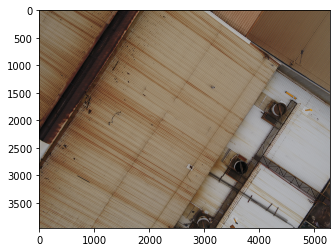

Terminado!


In [29]:
from engine import train_one_epoch, evaluate
import utils
from IPython.display import display

def main():
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    torch.manual_seed(0)
    np.random.seed(0)
    root_path = "./Ternium/"
    device = torch.device('cuda')
    model.to(device)
    
    # Parámetros de DataLoader, si tengo tamaños variables de anotaciones debe ser batch_size=1
    params = {
    'batch_size':2,
    'shuffle': True,
    'num_workers': 4,
    'collate_fn':utils.collate_fn
    }
    epochs = 1

    # ---------------- DEBUGING IMPORTANTE -------------------------
    #training_set = TerniumDataset(root_path)
    #print("dataset1",training_set[0])
    #seguir = input('Seguir')
    
    
    #print("dataset2",training_set[0])
    #seguir = input('Seguir')
    
    
    #images,targets = next(iter(training_generator))
    #images = images.to(device)
    #print("images 1: ",images)
    #print("targets 1: ",targets)
    
    #seguir = input('Seguir')
    
    #targets = [{k: v for k, v in t.items()} for t in targets]
    #targets = [{key:value for (key,value) in targets.items()}]
    #images = list(image.to(device) for image in images)
    #print("images2",images)
    #print("targets 2",targets)
    
    #seguir = input('Seguir')
    # ----------------------------------------------------------------
    
    # Datasets y Generators
    training_set = TerniumDataset(root_path, get_transform(train=True))
    training_generator = torch.utils.data.DataLoader(training_set, **params)
    
    # Construct an optimizer
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
    
    # and a learning rate scheduler
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
    
    for epoch in range(epochs):
        print("\n==============================\n")
        print("Epoch = " + str(epoch))
        
        # Training con utils
        train_one_epoch(model, optimizer, training_generator, device, epoch, print_freq=10)
        
        # update the learning rate
        lr_scheduler.step()
        
        # evaluate on the test dataset
        #evaluate(model, data_loader_test, device=device)
        
        # -------------------------- Training a mano -------------------------------------------
        # El batch_idx es un arreglo de tamaño bach_size con las imagenes dentro del batch
        '''
        for batch_idx, batch in training_generator:
            images = list(image.to(device) for image in batch_idx)
            targets = []
            for b in batch:
                target = {}
                target['labels'] = b['labels'].to(device)
                target['boxes']  = b['boxes'].to(device)
                targets.append(target)
            output = model(images, targets)
            print(output)
            
            #del images
            #torch.cuda.empty_cache()
        '''
        # ------------------------------------------------------------------------------------------
    
    # pick one image from the test set
    img, _ = training_set[0]
    # put the model in evaluation mode
    model.eval()
    with torch.no_grad():
        prediction = model([img.to(device)])
    print(prediction)
    im = Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())
    plt.imshow(im)
    plt.show()
    
if __name__ == "__main__":
    main()
    torch.cuda.empty_cache()
    print("Terminado!")

In [23]:
torch.cuda.empty_cache()
torch.cuda.memory_allocated(device)
torch.cuda.memory_summary(device)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |       0 B  |    3557 MB |    1080 GB |    1080 GB |\n|       from large pool |       0 B  |    3532 MB |    1069 GB |    1069 GB |\n|       from small pool |       0 B  |      62 MB |      10 GB |      10 GB |\n|---------------------------------------------------------------------------|\n| Active memory         |       0 B  |    3557 MB |    1080 GB |    1080 GB |\n|       from large pool |       0 B  |    3532 MB |

In [ ]:
# Read a batch of trainning images along with their bounding boxes and labels.
In this example I use read onle 1 image, batch_size = 1

(3956, 5280, 3)


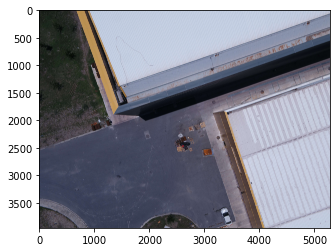

In [96]:
# input image could be of any size
img = cv2.imread('../input/Ternium/2018-05-28_13-24-30.JPG')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
print(img.shape)
plt.imshow(img)
plt.show()

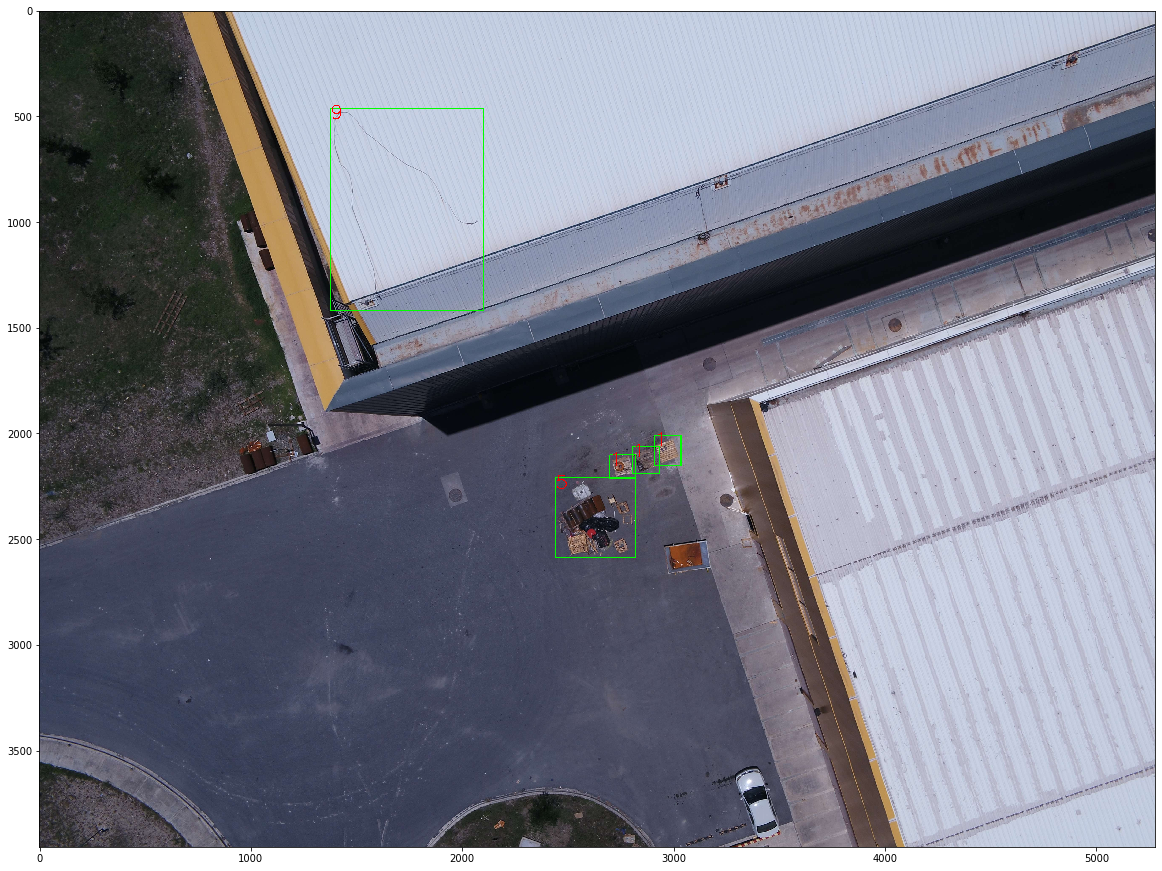

In [105]:
# display bounding box and labels
# cv2.putText
img_clone = np.copy(img)
for i in range(len(bbox)):
    cv2.rectangle(img_clone, (bbox[i][0], bbox[i][1]), (bbox[i][2], bbox[i][3]), color=(0,255,0), thickness=3)
    cv2.putText(img_clone, str(int(labels[i])), (bbox[i][0], bbox[i][1] + 50), cv2.FONT_HERSHEY_SIMPLEX, 3, (255,0,0), thickness=3)

plt.figure(figsize = (20,20))
plt.imshow(img_clone, interpolation='nearest')
plt.show()
    

# Resize the input images to (800x800) 

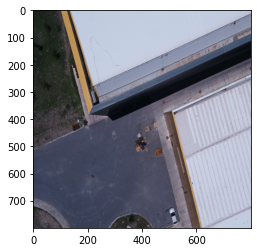

In [106]:
img = cv2.resize(img, dsize=(800,800), interpolation=cv2.INTER_CUBIC)
plt.imshow(img)
plt.show()

In [107]:
# Change the bounding box coordinates
w_ratio = 800 / img_clone.shape[1]
h_ratio = 800 / img_clone.shape[0]
ratioLst = [h_ratio, w_ratio, h_ratio, w_ratio]
bbox2 = []
for box in bbox:
    box2 = [int(a * b) for a,b in zip(box, ratioLst)]
    bbox2.append(box2)
bbox2 = np.array(bbox2)
bbox = bbox2
print(bbox)

[[278  70 424 215]
 [588 304 614 326]
 [567 312 593 331]
 [546 318 570 335]
 [494 335 570 391]]


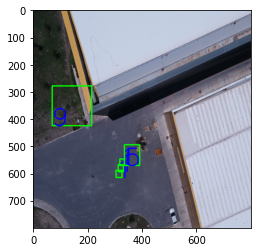

In [108]:
# Display bounding box and labels
img_clone = np.copy(img)
bbox_clone = bbox.astype(int)
for i in range(len(bbox)):
    cv2.rectangle(img_clone, (bbox[i][1], bbox[i][0]), (bbox[i][3], bbox[i][2]), color=(0,255,0), thickness=3)
    cv2.putText(img_clone, str(int(labels[i])), (bbox[i][1], bbox[i][2]), cv2.FONT_HERSHEY_SIMPLEX, 3, (0,0,255), thickness=3)
plt.imshow(img_clone)
plt.show()

# Use VGG16 to extract features from input images
Input images (batch_size, h=800,w=800,d=3)
Features; (batch_size, h=50,w=50,d=512)

In [109]:
from tqdm import tqdm
from ipywidgets import FloatProgress
# List all the layers of VGG16
model = torchvision.models.vgg16(pretrained=True).to(device)
fe = list(model.features)
print(len(fe))

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /home/crowbar/.cache/torch/hub/checkpoints/vgg16-397923af.pth



31
